In [1]:
import sys
import os
import warnings

import pandas as pd
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import scipy
import scipy.stats as st
from scipy.optimize import minimize
import random
import math

%matplotlib inline

# Import data

In [2]:
path_data = os.path.join("data", "processed.csv")

In [3]:
%%time
df = pd.read_csv(path_data, sep=";")
print "# rows: {}".format(len(df))

# rows: 28439141
Wall time: 54.9 s


In [4]:
df.dtypes

BETRIEBSTAG            object
FAHRT_BEZEICHNER       object
BETREIBER_ID           object
VERKEHRSMITTEL_TEXT    object
BPUIC                   int64
ANKUNFTSZEIT           object
AN_PROGNOSE            object
ABFAHRTSZEIT           object
AB_PROGNOSE            object
dtype: object

In [5]:
dateparser_ddmmyyy = '%d.%m.%Y'
dateparser_ddmmyyHHMM = '%d.%m.%Y %H:%M'
dateparser_ddmmyyHHMMSS = '%d.%m.%Y %H:%M:%S'

In [6]:
%%time
df["BETRIEBSTAG"] = pd.to_datetime(df["BETRIEBSTAG"], format=dateparser_ddmmyyy)
df["ANKUNFTSZEIT"] = pd.to_datetime(df["ANKUNFTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AN_PROGNOSE"] = pd.to_datetime(df["AN_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)
df["ABFAHRTSZEIT"] = pd.to_datetime(df["ABFAHRTSZEIT"], format=dateparser_ddmmyyHHMM)
df["AB_PROGNOSE"] = pd.to_datetime(df["AB_PROGNOSE"], format=dateparser_ddmmyyHHMMSS)

Wall time: 9min 24s


In [7]:
df.dtypes

BETRIEBSTAG            datetime64[ns]
FAHRT_BEZEICHNER               object
BETREIBER_ID                   object
VERKEHRSMITTEL_TEXT            object
BPUIC                           int64
ANKUNFTSZEIT           datetime64[ns]
AN_PROGNOSE            datetime64[ns]
ABFAHRTSZEIT           datetime64[ns]
AB_PROGNOSE            datetime64[ns]
dtype: object

In [8]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT


In [9]:
%%time
df["VERSPAETUNG_AN"] = df["AN_PROGNOSE"] - df["ANKUNFTSZEIT"]
df["VERSPAETUNG_AB"] = df["AB_PROGNOSE"] - df["ABFAHRTSZEIT"]

Wall time: 2.33 s


In [10]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT


In [11]:
%%time
df_ic = df[df["VERKEHRSMITTEL_TEXT"] == "IC"]

Wall time: 3.47 s


In [12]:
%%time
df_s = df[df["VERKEHRSMITTEL_TEXT"] == "S"]

Wall time: 3.24 s


# Overal arrival and departure delay

In [13]:
%%time
df_an_versp = df["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null arr-delays: {}".format(len(df_an_versp))

# non-null arr-delays: 24970365
Wall time: 3min 11s


In [14]:
left = -5.0
right = 15.00000001
step = 0.25

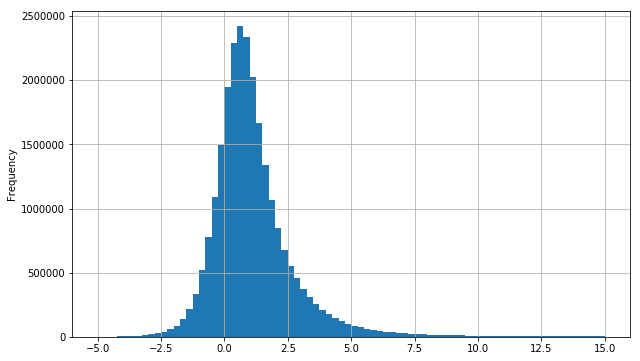

In [15]:
an_range = np.arange(left, right, step)
df_an_versp.plot.hist(bins=an_range, figsize=(10, 6), grid=True)

# non-null ic-arr-delays: 583939
Wall time: 4.27 s


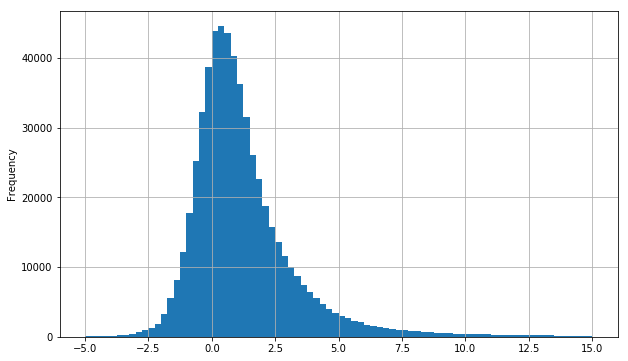

In [16]:
%%time
df_an_versp_ic = df_ic["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null ic-arr-delays: {}".format(len(df_an_versp_ic))
df_an_versp_ic.plot.hist(bins=an_range, figsize=(10, 6), grid=True)

# non-null s-arr-delays: 17678577
Wall time: 2min 12s


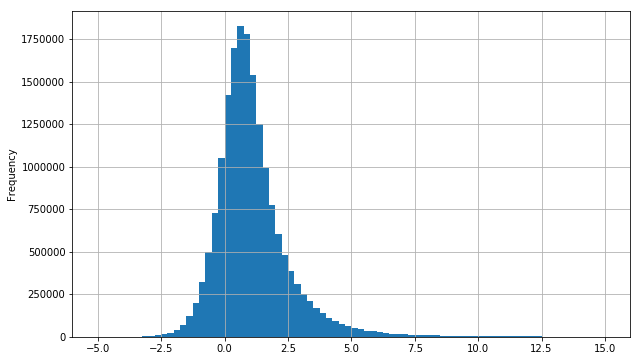

In [17]:
%%time
df_an_versp_s = df_s["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null s-arr-delays: {}".format(len(df_an_versp_s))
df_an_versp_s.plot.hist(bins=an_range, figsize=(10, 6), grid=True)

In [18]:
df_ab_versp = df["VERSPAETUNG_AB"].dropna().apply(lambda d: d.total_seconds() / 60.0)
print "# non-null dep-delays: {}".format(len(df_ab_versp))

# non-null dep-delays: 25619629


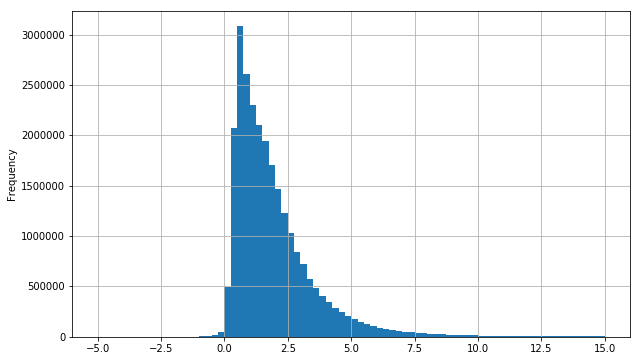

In [19]:
ab_range = np.arange(left, right, step)
df_ab_versp.plot.hist(bins=ab_range, figsize=(10, 6), grid=True)

# Grouping

In [20]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT


In [21]:
%%time
df["TRAIN_ID"] = df["FAHRT_BEZEICHNER"].apply(lambda x: ":".join(x.split(":")[:-1]))

Wall time: 19.3 s


In [22]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB,TRAIN_ID
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT,80:807000:19700
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56,80:807000:19701
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT,80:807000:19702
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35,80:807000:19703
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT,80:807000:19704


In [ ]:
df_non_nan_arrs = df.d

In [23]:
%%time
gpd = df.groupby(["TRAIN_ID", "BPUIC"])

Wall time: 1.92 s


In [24]:
%%time
df_tt = df[["TRAIN_ID", "BPUIC", "ANKUNFTSZEIT", "ABFAHRTSZEIT", "BETRIEBSTAG"]].groupby(["TRAIN_ID", "BPUIC"]).agg({"ANKUNFTSZEIT": min, "ABFAHRTSZEIT": min, "BETRIEBSTAG": len}).reset_index().sort_values(by=["TRAIN_ID", "ABFAHRTSZEIT", "ANKUNFTSZEIT"])
df_tt = df_tt.rename(columns={"BETRIEBSTAG": "COUNT"})
df_tt = df_tt[["TRAIN_ID", "BPUIC", "ANKUNFTSZEIT", "ABFAHRTSZEIT", "COUNT"]]

Wall time: 8.29 s


In [25]:
%%time
df_tt.to_csv(os.path.join("data", "train_bp_uic_counts.csv"), sep=";", index=False)

Wall time: 1.84 s


# Optimization

## Distributions

In [65]:
all_distributions = set([x for x in st._continuous_distns.__dict__["__all__"] if not x.endswith("_gen")])
print "# continous distributions: {}".format(len(all_distributions))
excluded_distributions = set([
    'rv_histogram', # not a distribution (?)
    'levy_stable', # fit is very slow
])
print "# excluded distributions: {}".format(len(excluded_distributions))
analysed_distributions = sorted(list(all_distributions - excluded_distributions))
print "# analysed distributions: {}".format(len(analysed_distributions))

# continous distributions: 99
# excluded distributions: 2
# analysed distributions: 97


In [74]:
l = []
nb_shape_params_per_dist_name = {}
for d in analysed_distributions:
    dist = getattr(scipy.stats, d)
    nb_shape_params_per_dist_name[d] = len(dist.shapes) if dist.shapes else 0

In [67]:
dist_names_large = [
    'alpha',
    'anglit',
    'arcsine',
    'beta',
    'betaprime',
    'bradford',
    'burr',
    'cauchy',
    'chi',
    'chi2',
    'cosine',
    'dgamma',
    'dweibull',
    'erlang',
    'expon',
    'exponnorm',
    'exponweib',
    'exponpow',
    'f',
    'fatiguelife',
    'fisk',
    'foldcauchy',
    'foldnorm',
    'frechet_r',
    'frechet_l',
    'genlogistic',
    'genpareto',
    'gennorm',
    'genexpon',
    'genextreme',
#     'gausshyper',
    'gamma',
    'gengamma',
    'genhalflogistic',
    'gilbrat',
    'gompertz',
    'gumbel_r',
    'gumbel_l',
    'halfcauchy',
    'halflogistic',
    'halfnorm',
    'halfgennorm',
    'hypsecant',
    'invgamma',
    'invgauss',
    'invweibull',
    'johnsonsb',
    'johnsonsu',
    'ksone',
    'kstwobign',
    'laplace',
    'levy',
    'levy_l',
#     'levy_stable',
    'logistic',
    'loggamma',
    'loglaplace',
    'lognorm',
    'lomax',
    'maxwell',
    'mielke',
    'nakagami',
    'ncx2',
#     'ncf',
    'nct',
    'norm',
    'pareto',
    'pearson3',
    'powerlaw',
    'powerlognorm',
    'powernorm',
#     'rdist',
    'reciprocal',
    'rayleigh',
    'rice',
    'recipinvgauss',
    'semicircular',
    't',
    'triang',
    'truncexpon',
    'truncnorm',
    'tukeylambda',
    'uniform',
    'vonmises',
    'vonmises_line',
    'wald',
    'weibull_min',
    'weibull_max',
    'wrapcauchy',
]

In [68]:
dist_names_small = [
    'norm', 
    'lognorm',
    'weibull_min',
     'weibull_max',
    'alpha',
    'cauchy',
    'powerlognorm',
    'chi',
    'erlang',
    'expon',
    'gamma',
    'gumbel_r',
    'halfcauchy',
    'maxwell',
    'wald',
    'levy',
    'levy_l',
    'pareto',
]


## Definition

In [69]:
def optimize(dist_name, data, opt_type='kst'):
    dist = getattr(scipy.stats, dist_name)
    first_guess_data = data if len(data) < 365 else [random.choice(data) for _ in range(365)]
    first_guess = dist.fit(first_guess_data)
    left = -5.0
    right = 10.0000000000000001
    step = 0.25
    r = np.arange(left, right, step)
    hist_emp = np.histogram(data, r, density=True)[0]
    r_m = np.array([(r[i] + r[i + 1]) / 2.0 for i in range(len(r) - 1)])
    def fun_eval(act_paras, opt_type=opt_type):
        if opt_type == 'kst':
            d, p = scipy.stats.kstest(data, dist_name, act_paras)
            return d
        else:
            hist_exp = dist.pdf(r_m, *act_paras[:-2], loc=act_paras[-2], scale=act_paras[-1])
            if opt_type == 'cst':
                return st.chisquare(hist_emp, f_exp=hist_exp).statistic
            elif opt_type == 'ss':
                return np.power(hist_emp - hist_exp, 2.0).sum()
            elif opt_type == 'as':
                return np.absolute(hist_emp - hist_exp).sum()
            else:
                raise ValueError("{} is not a valid argument".format(opt_type))
    opt_paras = minimize(fun_eval, first_guess, method='nelder-mead')
    return opt_paras

In [105]:
def evaluate(data, dist_names=analysed_distributions, left=left, right=right, step=step, plot_best_n=5, title=""):
    # plot data
    x = np.arange(left, right, step)
    y = np.array(data)
    plt.figure(figsize=(13,9))
    h = plt.hist(y, bins=x, color='black', density=False)

    # optimization per distribution
    res_per_dist_name = {}
    for dist_name in dist_names:
        print "\r {}".format(dist_name),
        try:
            res = optimize(dist_name, y, opt_type='as')
            res_per_dist_name[dist_name] = res
        except Exception as e:
            print "no success: {}".format(e)
    print "\r",
    # plot best distributions
    sorted_dist_name_res_pairs = sorted(res_per_dist_name.items(), key=lambda p: float("inf") if math.isnan(p[1].fun) else p[1].fun) # be aware: sorting not correct if nan's are not set to inf!!!
    x_dist=np.arange(left, right, 0.05)
    for dist_name, res in sorted_dist_name_res_pairs[:plot_best_n]:
        dist = getattr(scipy.stats, dist_name)
        param = res.x
        pdf_fitted = dist.pdf(x_dist, *param[:-2], loc=param[-2], scale=param[-1]) * h[0].sum() * step
        plt.plot(x_dist, pdf_fitted, label="{} {:.4f} {}".format(dist_name, res.fun, res.success))
    plt.xlim(x[0], x[-1])
    plt.legend(loc='upper right')
    plt.title(title)
    plt.xlabel("delay [min]")
    plt.ylabel("frequency")
    plt.show()
    return res_per_dist_name

## Analysis

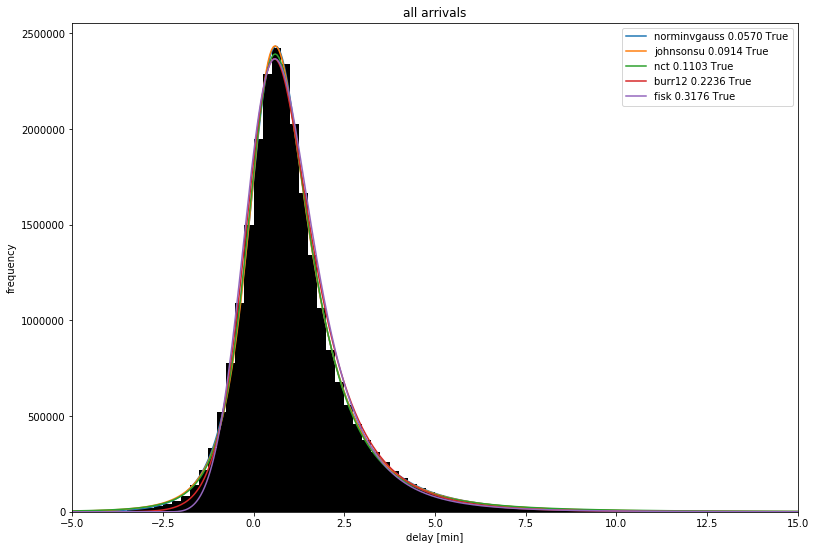

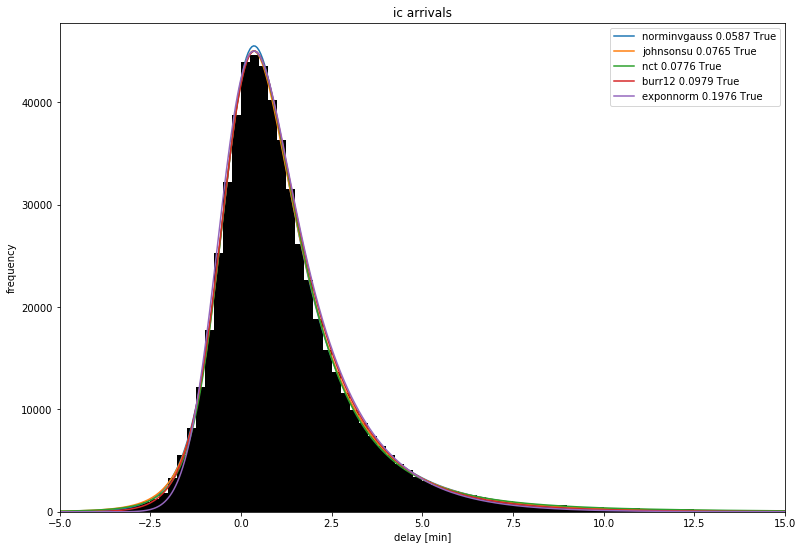

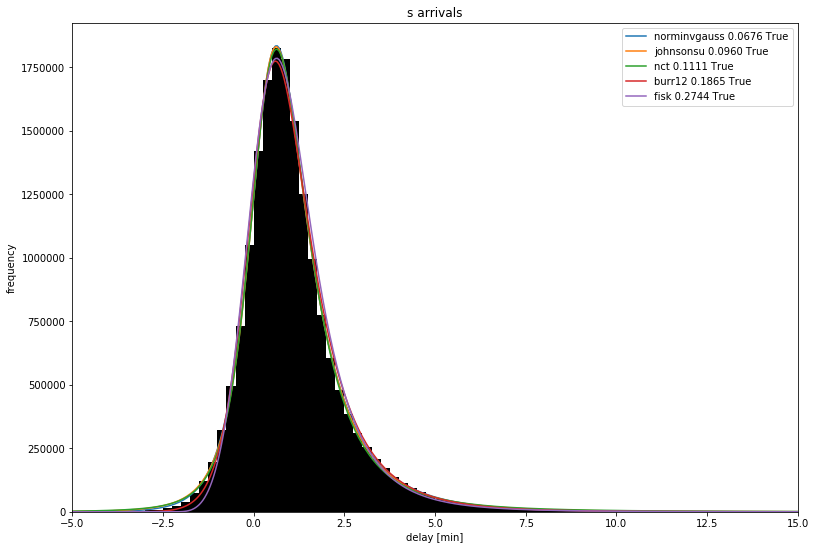

In [106]:
warnings.filterwarnings(action='ignore')
res_per_dist_name_all_an = evaluate(df_an_versp, title="all arrivals")
res_per_dist_name_ic_an = evaluate(df_an_versp_ic, title="ic arrivals")
res_per_dist_name_s_an = evaluate(df_an_versp_s, title="s arrivals")

In [75]:
funs = [["{} (#shape-params: {}; all: {}, ic: {}, s: {})".format(dist_name, nb_shape_params_per_dist_name[dist_name], res_per_dist_name_all_an[dist_name]["success"], res_per_dist_name_ic_an[dist_name]["success"], res_per_dist_name_s_an[dist_name]["success"]), res_per_dist_name_all_an[dist_name]["fun"], res_per_dist_name_ic_an[dist_name]["fun"],  res_per_dist_name_s_an[dist_name]["fun"]] for dist_name in res_per_dist_name_all_an.keys()]
df_funs = pd.DataFrame(funs, columns=["dist_name", "fun_all", "fun_ic", "fun_s"]).set_index("dist_name").sort_values(by=["fun_all"], ascending=False)

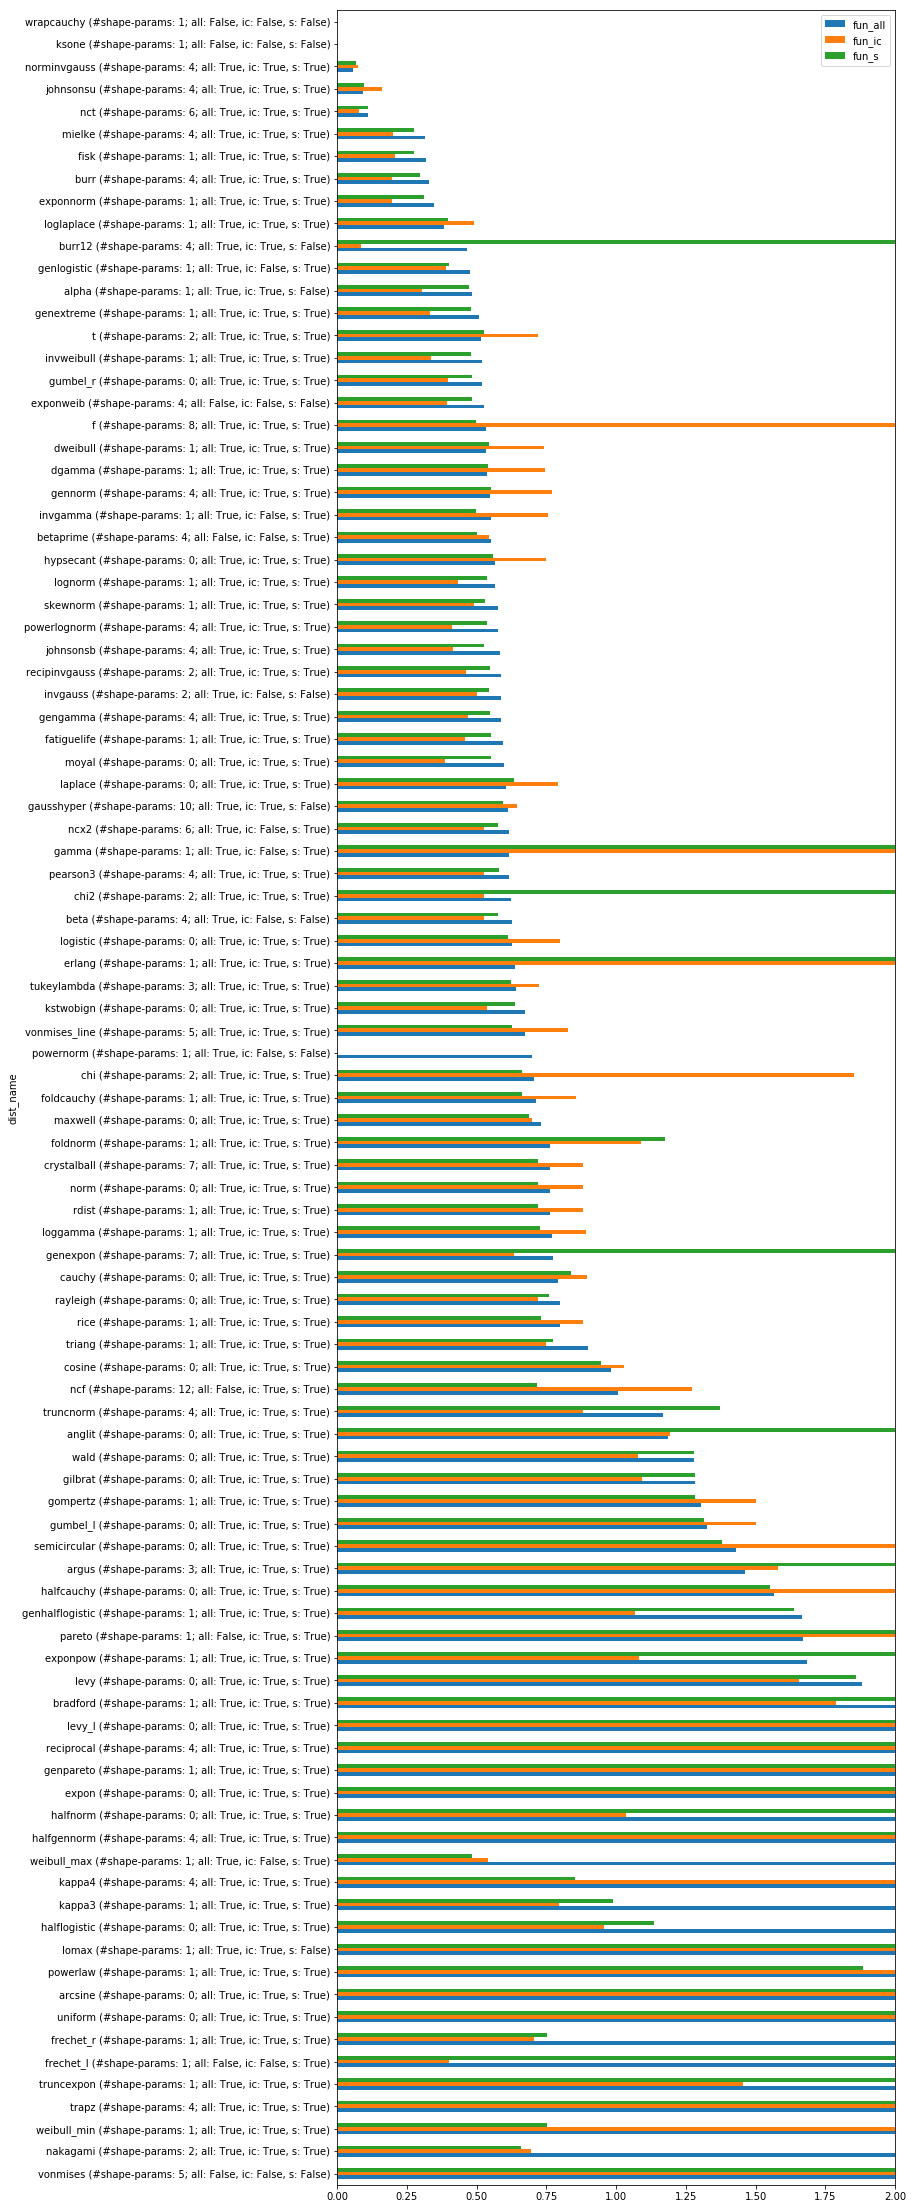

In [76]:
df_funs.plot(kind="barh", figsize=(10, 40), xlim=[0, 2])

In [125]:
def get_train_id_bpuic_pairs(df, min_nb_days=200):
    df_train_id_bpuic_count = df[["TRAIN_ID", "BPUIC", "VERSPAETUNG_AN"]].dropna().groupby(["TRAIN_ID", "BPUIC"]).count()
    df_train_id_bpuic_count = df_train_id_bpuic_count.rename(columns={"VERSPAETUNG_AN": "NB"})
    print len(df_train_id_bpuic_count)
    df_train_id_bpuic_count_filtered = df_train_id_bpuic_count[df_train_id_bpuic_count["NB"] > 200]
    print len(df_train_id_bpuic_count_filtered)
    filtered_train_id_bpuic_pairs = list(df_train_id_bpuic_count_filtered.index)
    return filtered_train_id_bpuic_pairs

In [77]:
def evaluate_arr_train_stop(train_id, bpuic, **kargs):
    data = df[(df["TRAIN_ID"] == train_id) & (df["BPUIC"] == bpuic)]["VERSPAETUNG_AN"].dropna().apply(lambda d: d.total_seconds() / 60.0)
    print len(data)
    evaluate(data, **kargs)

In [126]:
#filtered_train_id_bpuic_pairs_all = filtered_train_id_bpuic_pairs(df)
filtered_train_id_bpuic_pairs_ic = get_train_id_bpuic_pairs(df[df["VERKEHRSMITTEL_TEXT"] == "IC"])

9932
1762


In [129]:
def plot_random(l, n=10):
    for i in range(n):
        train_id, bpuic = random.choice(l)
        evaluate_arr_train_stop(train_id, bpuic, step=0.5, plot_best_n=10, title="{} {}".format(train_id, bpuic))

 228


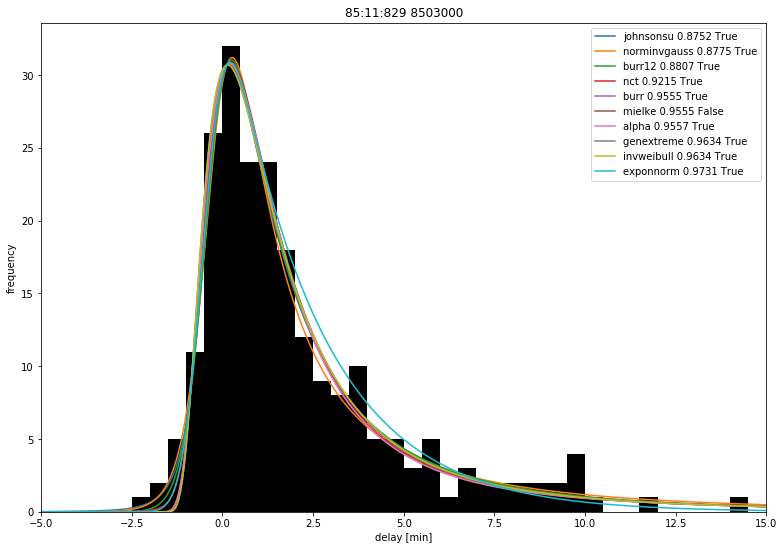

233


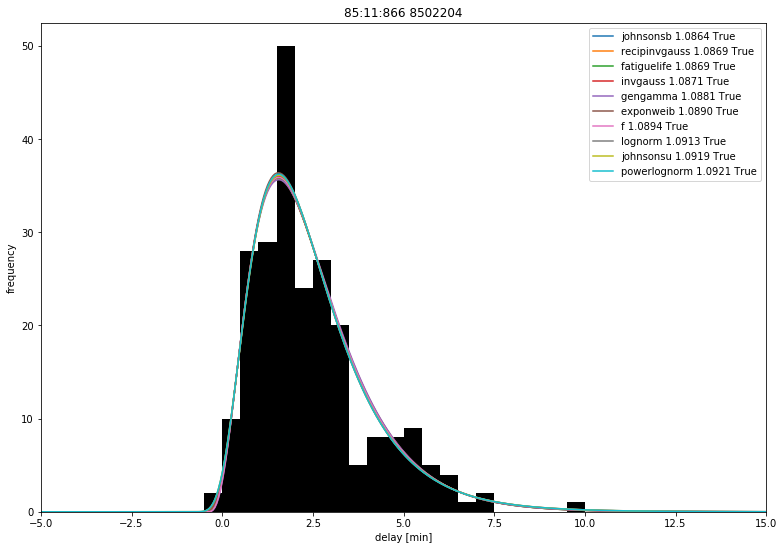

239


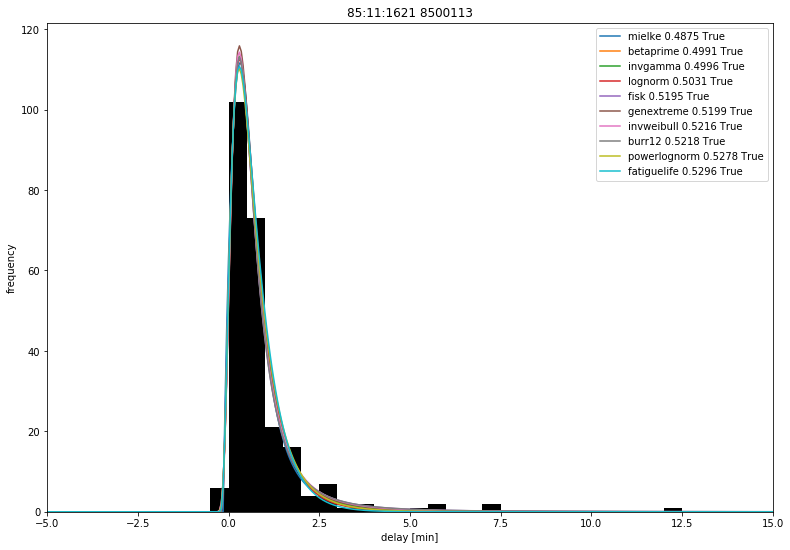

239


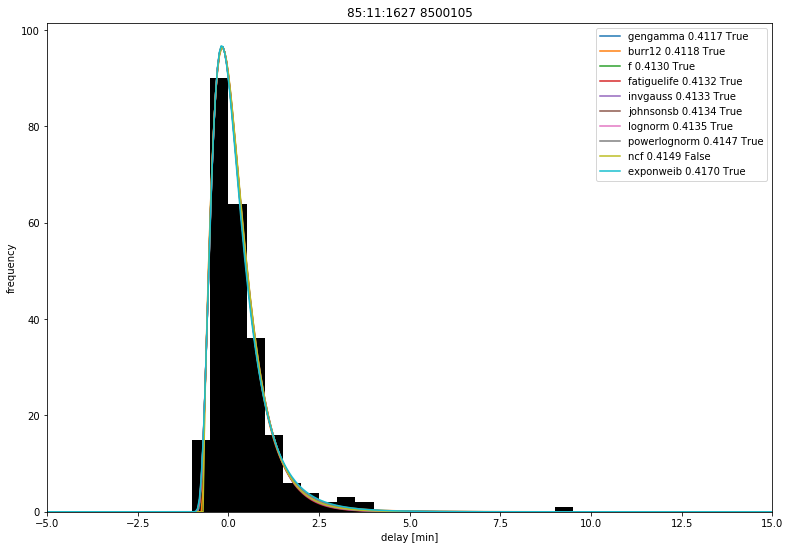

225


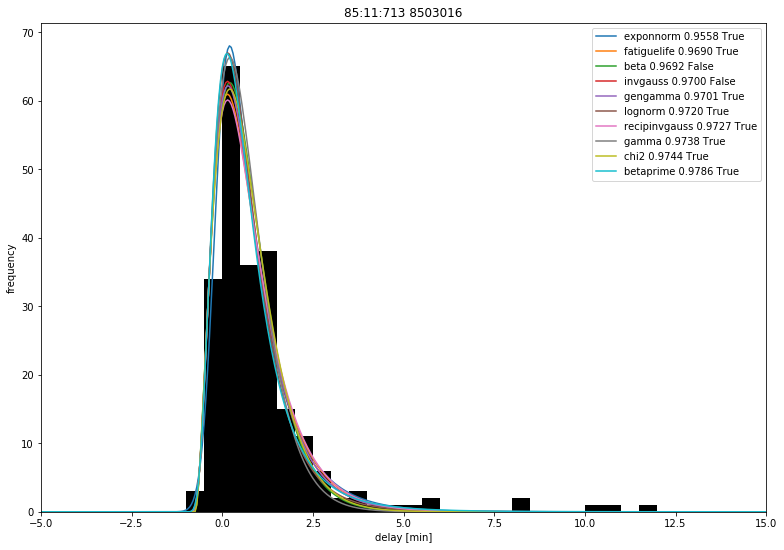

221


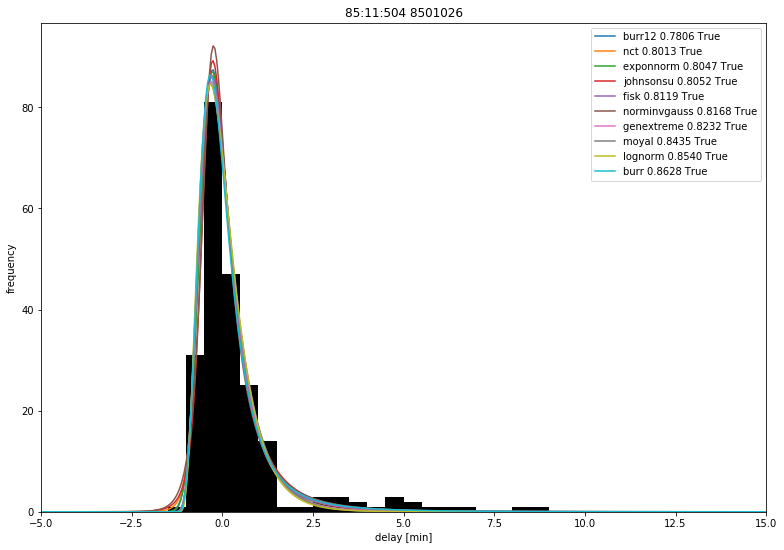

230


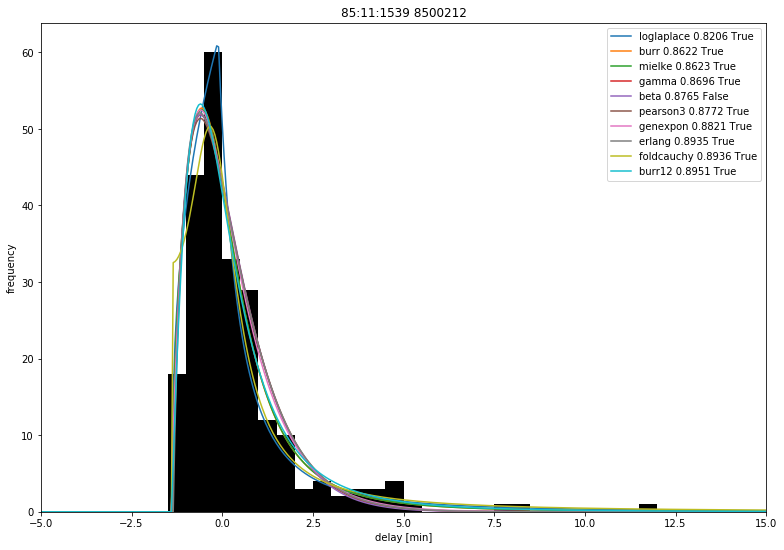

205


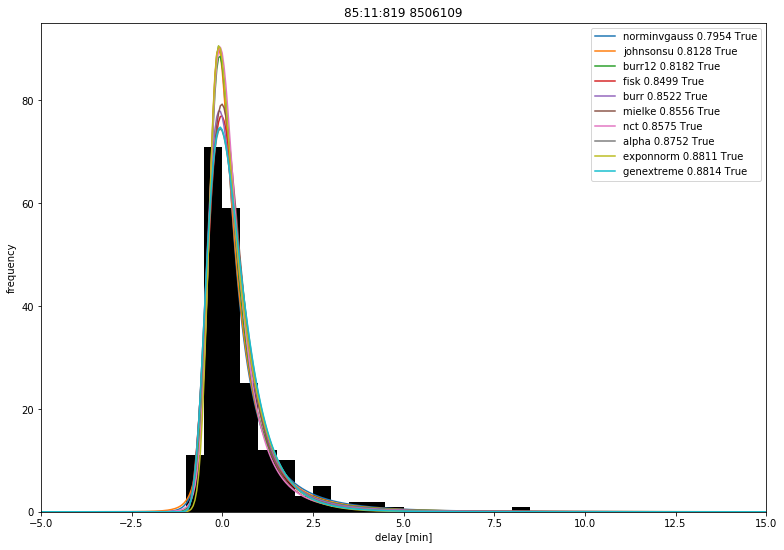

231


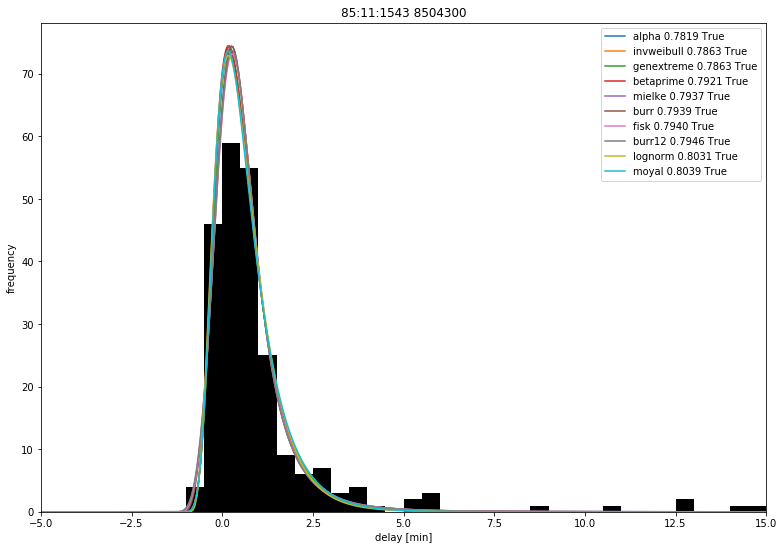

228


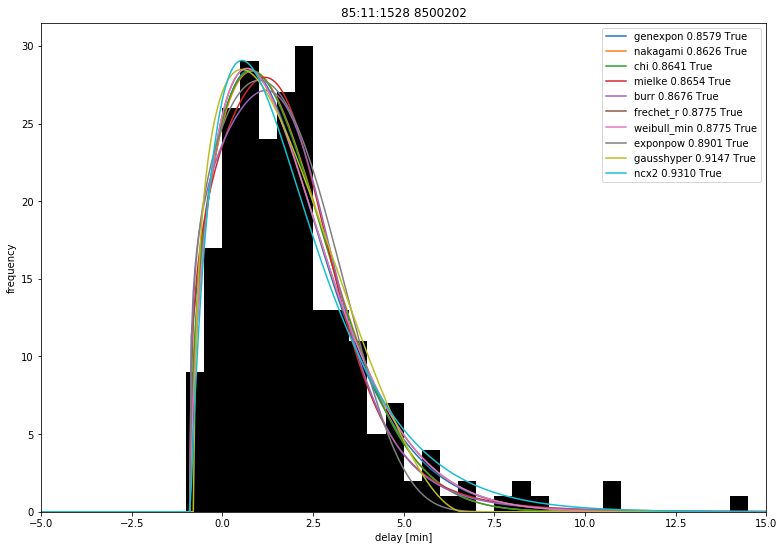

226


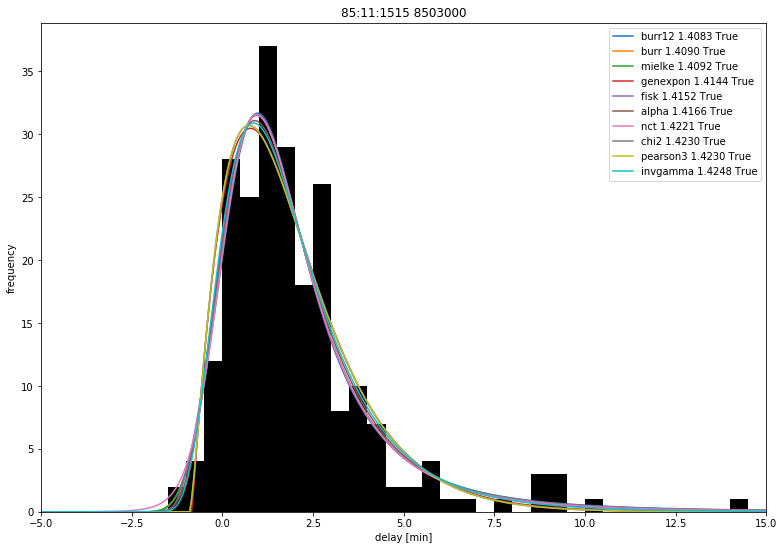

239


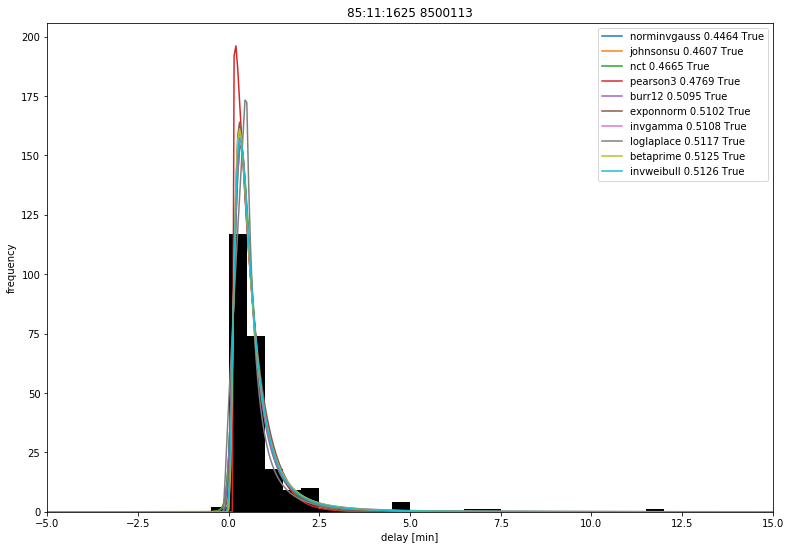

225


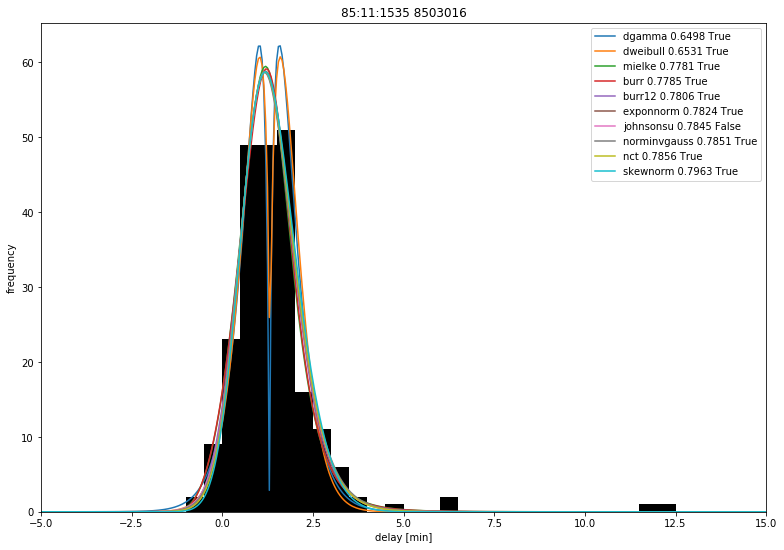

226


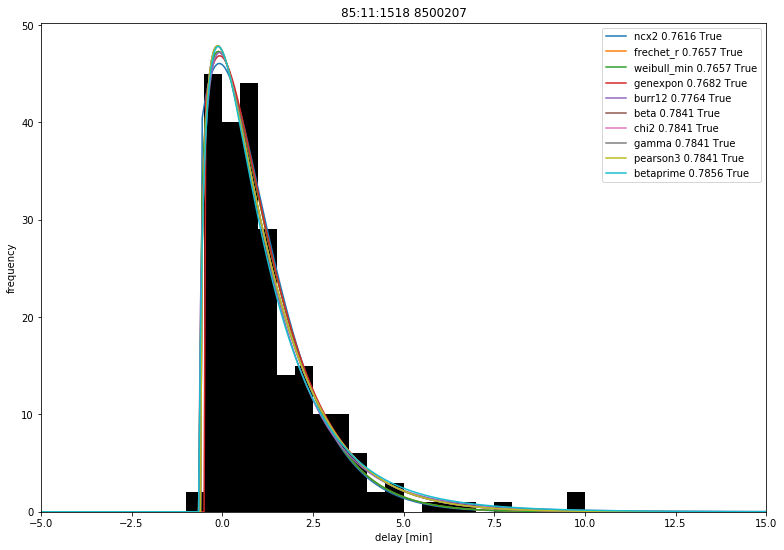

231


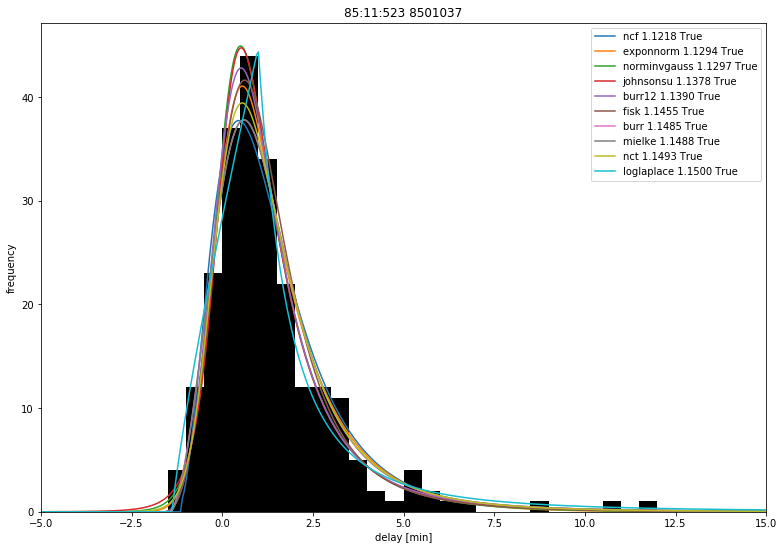

238


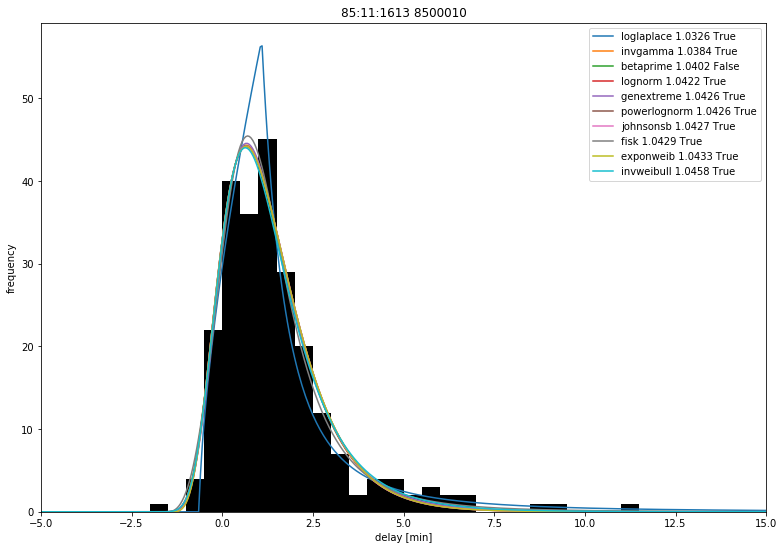

228


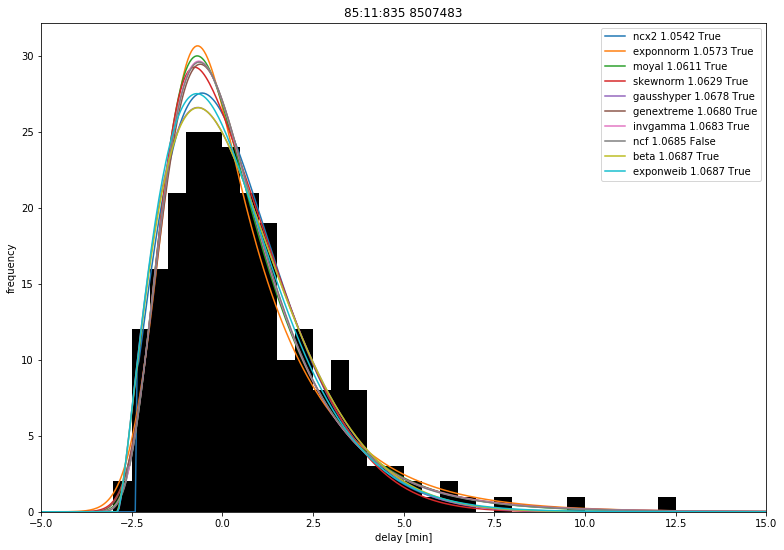

227


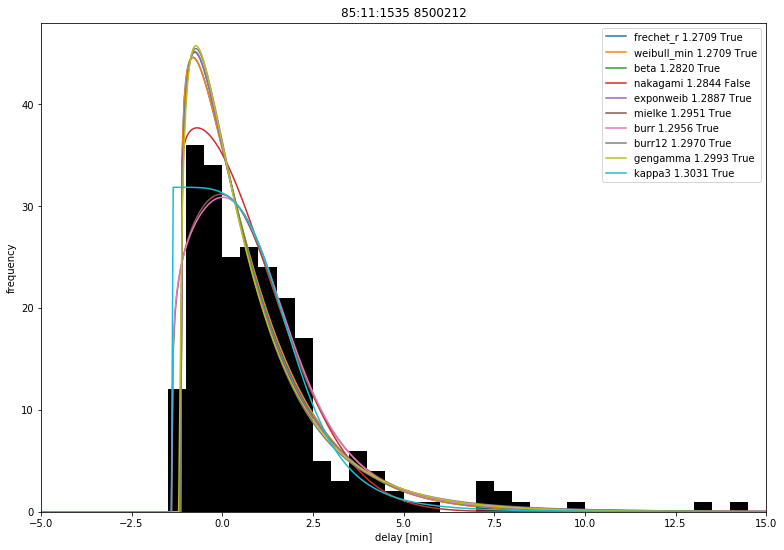

238


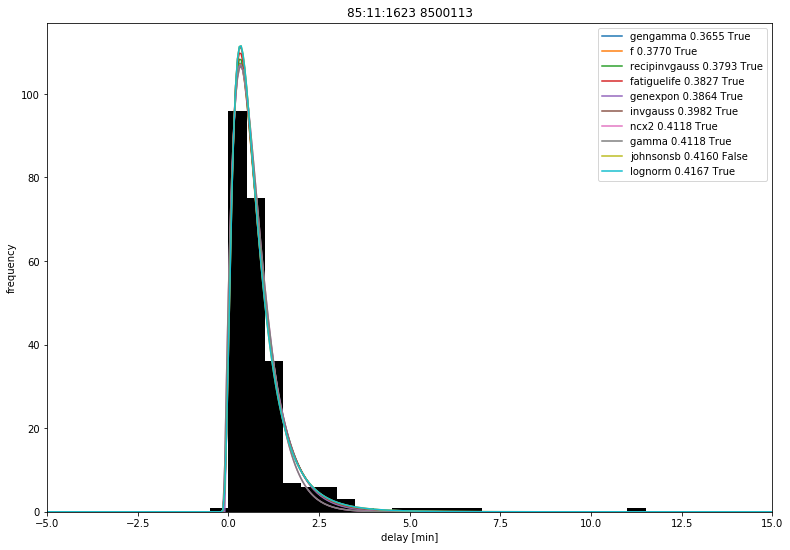

209


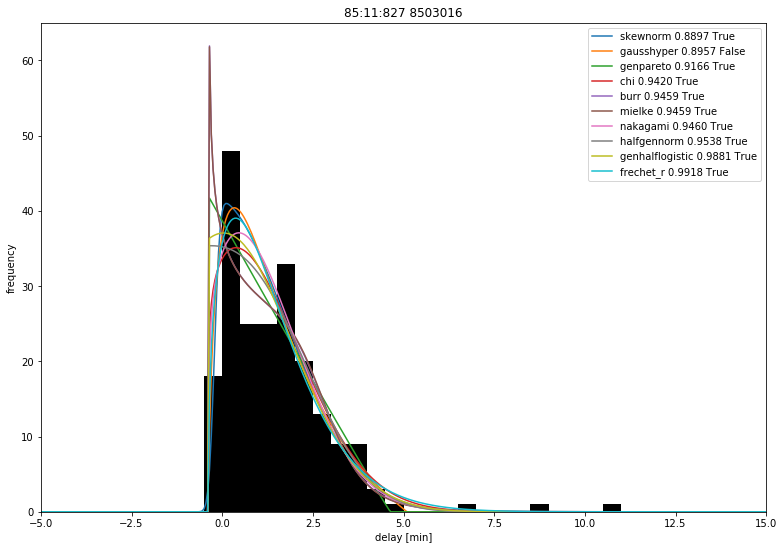

228


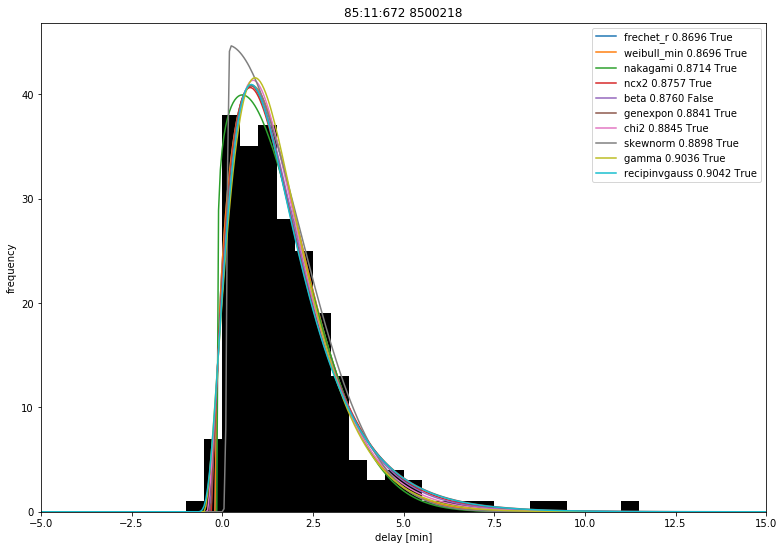

219


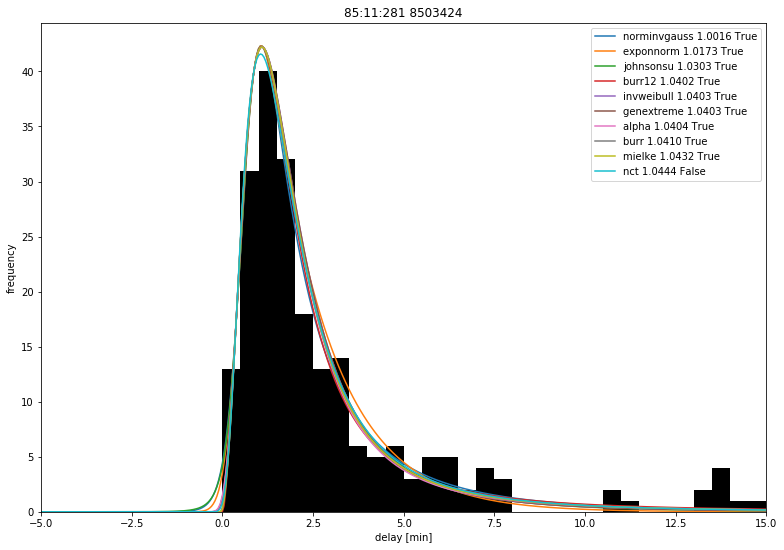

209


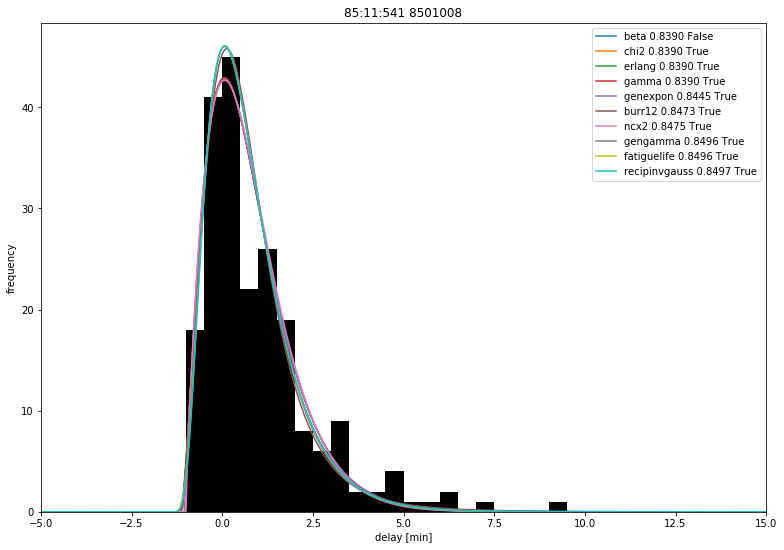

229


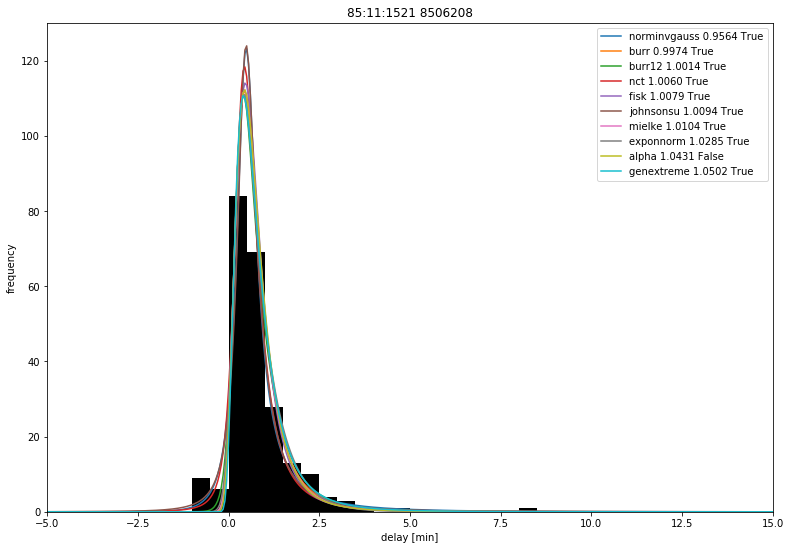

228


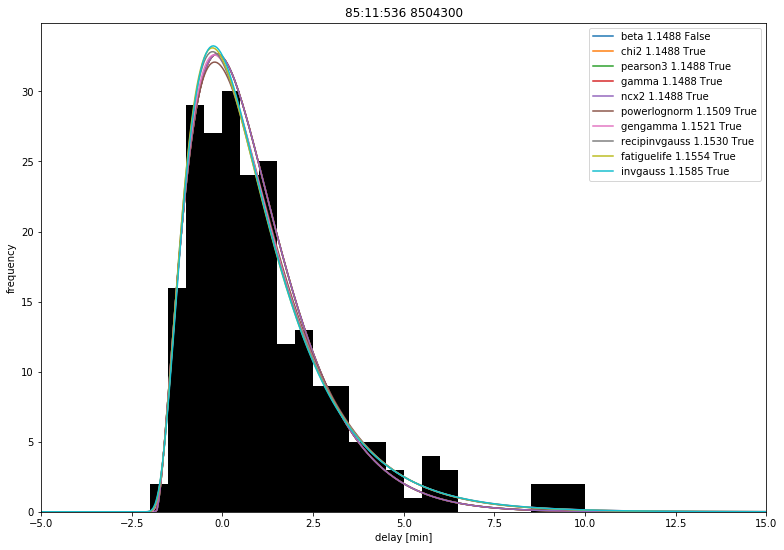

217


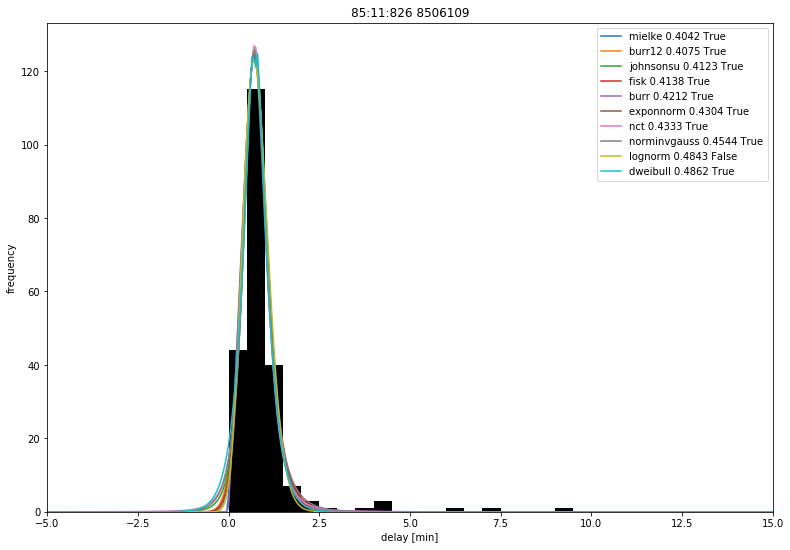

238


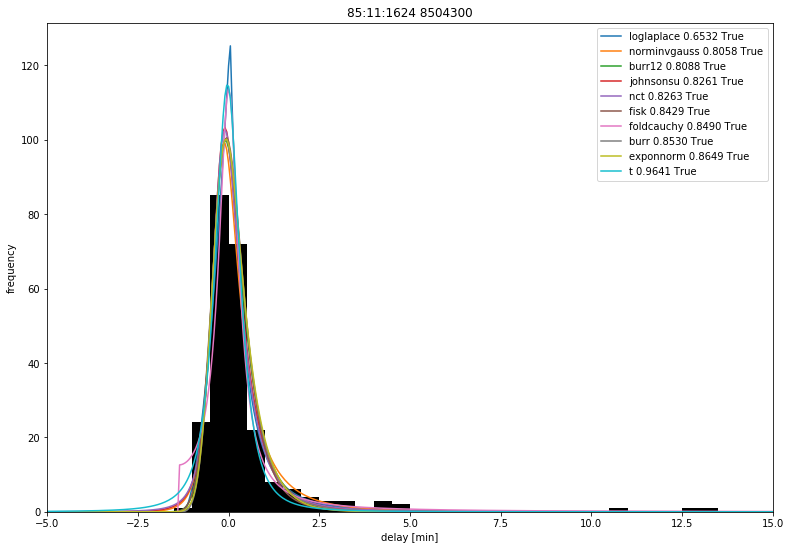

229


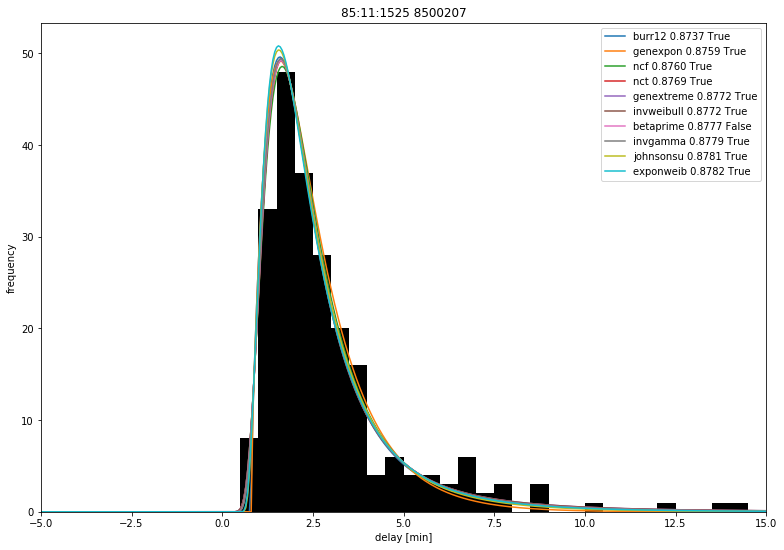

223


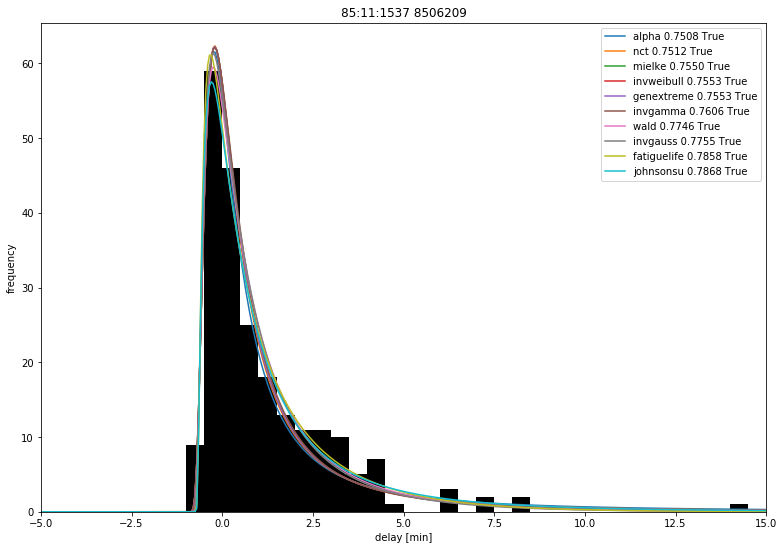

231


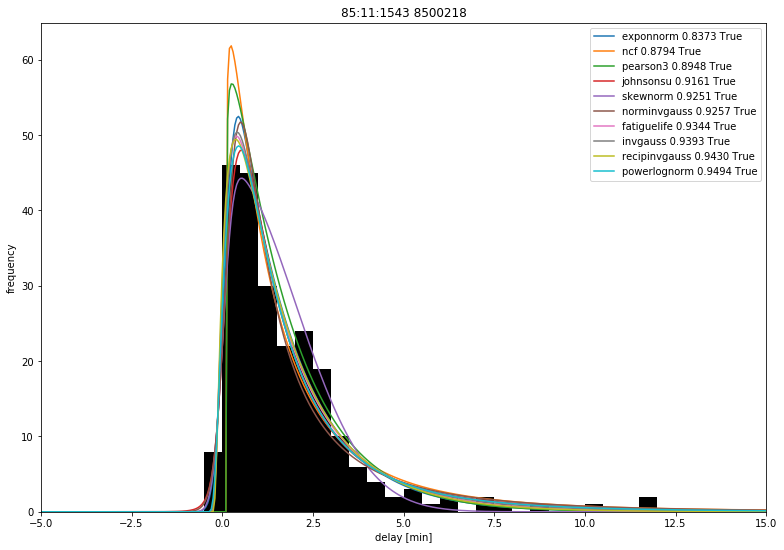

In [131]:
plot_random(filtered_train_id_bpuic_pairs_ic, n=30)

239
alpha
anglit
arcsine
argus
beta
betaprime
bradford
burr
burr12
cauchy
chi
chi2
cosine
crystalball
dgamma
dweibull
erlang
expon
exponnorm
exponpow
exponweib
f
fatiguelife
fisk
foldcauchy
foldnorm
frechet_l
frechet_r
gamma
gausshyper
genexpon
genextreme
gengamma
genhalflogistic
genlogistic
gennorm
genpareto
gilbrat
gompertz
gumbel_l
gumbel_r
halfcauchy
halfgennorm
halflogistic
halfnorm
hypsecant
invgamma
invgauss
invweibull
johnsonsb
johnsonsu
kappa3
kappa4
ksone
kstwobign
laplace
levy
levy_l
loggamma
logistic
loglaplace
lognorm
lomax
maxwell
mielke
moyal
nakagami
ncf
nct
ncx2
norm
norminvgauss
pareto
pearson3
powerlaw
powerlognorm
powernorm
rayleigh
rdist
recipinvgauss
reciprocal
rice
semicircular
skewnorm
t
trapz
triang
truncexpon
truncnorm
tukeylambda
uniform
vonmises
vonmises_line
wald
weibull_max
weibull_min
wrapcauchy


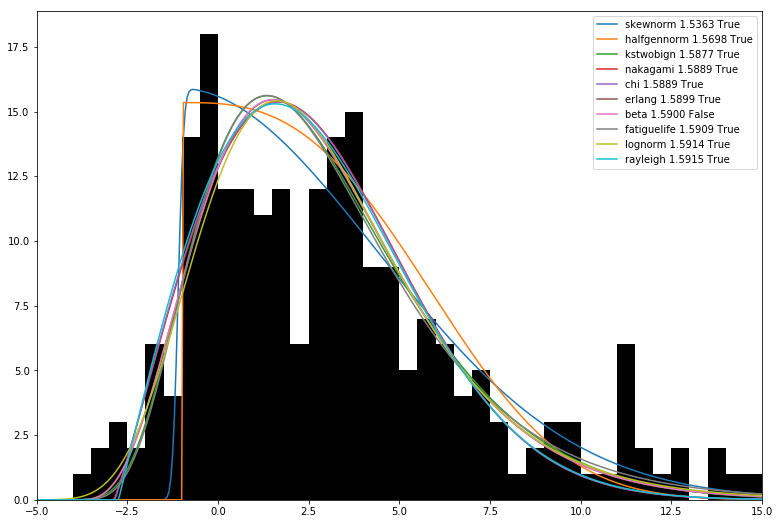

In [78]:
evaluate_arr_train_stop("85:11:22", 8505300, step=0.5, plot_best_n=10)

# Check for uniqueness

In [36]:
df.head()

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB,TRAIN_ID
0,2018-03-10,80:807000:19700:002,80:807000,RB,8503424,2018-03-10 05:54:00,2018-03-10 05:55:40,NaT,NaT,00:01:40,NaT,80:807000:19700
1,2018-03-10,80:807000:19701:001,80:807000,S,8503424,NaT,NaT,2018-03-10 05:28:00,2018-03-10 05:28:56,NaT,00:00:56,80:807000:19701
2,2018-03-10,80:807000:19702:004,80:807000,RB,8503424,2018-03-10 06:24:00,2018-03-10 06:24:49,NaT,NaT,00:00:49,NaT,80:807000:19702
3,2018-03-10,80:807000:19703:005,80:807000,S,8503424,NaT,NaT,2018-03-10 06:07:00,2018-03-10 06:07:35,NaT,00:00:35,80:807000:19703
4,2018-03-10,80:807000:19704:007,80:807000,RB,8503424,2018-03-10 06:54:00,2018-03-10 06:55:39,NaT,NaT,00:01:39,NaT,80:807000:19704


In [37]:
print "# BETRIEBSTAGE with delays: {}".format(len(df["BETRIEBSTAG"].unique()))

# BETRIEBSTAGE with delays: 240


In [38]:
df_count_per_day_train_id_bpuic = df[["BETRIEBSTAG", "TRAIN_ID", "BPUIC", "ABFAHRTSZEIT"]].groupby(["BETRIEBSTAG", "TRAIN_ID", "BPUIC"]).count()

In [39]:
print len(df_count_per_day_train_id_bpuic)

28439074


In [40]:
df_hmmm = df_count_per_day_train_id_bpuic[df_count_per_day_train_id_bpuic["ABFAHRTSZEIT"] > 1]

In [41]:
len(df_hmmm)

56

In [42]:
df_hmmm

ABFAHRTSZEIT
BETRIEBSTAG TRAIN_ID    BPUIC                
2018-09-29  85:22:1072  8506271             2
                        8506280             2
                        8506281             2
                        8506282             2
                        8506283             2
                        8506285             2
                        8506290             2
            85:22:1073  8506210             2
                        8506280             2
                        8506281             2
                        8506282             2
                        8506283             2
                        8506284             2
                        8506290             2
2018-10-19  85:81:9461  8500272             2
                        8500273             2
                        8500274             2
                        8500275             2
                        8500280             2
                        8500283             2
                        8500285             2
                        8500286             2
            85:81:9462  8500207             2
                        8500211             2
                        8500272             2
                        8500273             2
                        8500274             2
                        8500275             2
                        8500280             2
                        8500283             2
                        8500285             2
                        8500286             2
                        8500287             2
                        8500288             2
                        8500289             2
                        8518690             2
            85:81:9463  8500211             2
                        8500212             2
                        8500272             2
                        8500273             2
                        8500274             2
                        8500275             2
                        8500280             2
                        8500283             2
                        8500285             2
                        8500286             2
                        8500287             2
                        8500288             2
                        8500289             2
                        8518690             2
            85:81:9464  8500207             2
                        8500272             2
                        8500273             2
                        8500280             2
2018-10-21  85:11:10227 8501117             2
2018-12-14  85:65:11721 8506121             2

In [43]:
df[(df["BETRIEBSTAG"] == "2018-10-21") & (df["TRAIN_ID"] == "85:11:10227") & (df["BPUIC"] == 8501117)]

,BETRIEBSTAG,FAHRT_BEZEICHNER,BETREIBER_ID,VERKEHRSMITTEL_TEXT,BPUIC,ANKUNFTSZEIT,AN_PROGNOSE,ABFAHRTSZEIT,AB_PROGNOSE,VERSPAETUNG_AN,VERSPAETUNG_AB,TRAIN_ID
19721151,2018-10-21,85:11:10227:001,85:11,NZ,8501117,2018-10-22 00:13:00,2018-10-22 00:13:53,2018-10-22 00:15:00,NaT,00:00:53,NaT,85:11:10227
19721153,2018-10-21,85:11:10227:001,85:11,NZ,8501117,2018-10-22 00:27:00,NaT,2018-10-22 00:27:00,2018-10-22 00:48:04,NaT,00:21:04,85:11:10227
